本实践使用多层感知器训练（DNN）模型，用于预测手写数字图片。

![](https://ai-studio-static-online.cdn.bcebos.com/ba26eac845334208851e72c7a2dfef5e1eec566894ba430aba7492e72c49cacd)

首先导入必要的包

numpy---------->python第三方库，用于进行科学计算

PIL------------> Python Image Library,python第三方图像处理库

matplotlib----->python的绘图库 pyplot:matplotlib的绘图框架

os------------->提供了丰富的方法来处理文件和目录
torchvision----->提供很多数据集的下载，包括COCO，ImageNet，CIFCAR等


In [1]:
#导入需要的包
import numpy as np
import torch 
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
import os
from torchvision import datasets, transforms,utils

# **Step1：准备数据。**

(1)数据集介绍

MNIST数据集包含60000个训练集和10000测试数据集。分为图片和标签，图片是28*28的像素矩阵，标签为0~9共10个数字。

![](https://ai-studio-static-online.cdn.bcebos.com/fc73217ae57f451a89badc801a903bb742e42eabd9434ecc8089efe19a66c076)

(2)data_train和data_test
root为数据集存放的路径，transform指定数据集导入的时候需要进行的变换，train设置为true表明导入的是训练集合，否则会测试集合。
Compose是把多种数据处理的方法集合在一起。使用transforms进行Tensor格式转换和Batch Normalization。
参考：
https://zhuanlan.zhihu.com/p/37857371
https://zhuanlan.zhihu.com/p/30249139
（3）打印看下数据是什么样的？数据已经经过transform的归一化处理

class torchvision.transforms.Normalize(mean, std)：
给定均值：(R,G,B) 方差：（R，G，B），将会把Tensor正则化。即：Normalized_image=(image-mean)/std.
MINIST是（1,28,28）不是RGB的三维，只有一维的灰度图数据，所以不是[0.5,0.5,0.5],而是[0.5]

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5],std=[0.5])])

In [3]:
train_data = datasets.MNIST(root = "./data/",
                            transform=transform,
                            train = True,
                            download = True)

test_data = datasets.MNIST(root="./data/",
                           transform = transform,
                           train = False)

数据下载慢的问题：https://blog.csdn.net/qq_31904559/article/details/96591484?depth_1-utm_source=distribute.pc_relevant.none-task&utm_source=distribute.pc_relevant.none-task

In [4]:
len(test_data)

10000

train_data 的个数：60000个训练样本

test_data 的个数：10000个训练样本

一个样本的格式为[data,label]，第一个存放数据，第二个存放标签

https://pytorch-cn.readthedocs.io/zh/latest/package_references/data/
num_workers 表示用多少个子进程加载数据
shuffle 表示在装载过程中随机乱序

In [5]:
train_loader = torch.utils.data.DataLoader(train_data,batch_size=64,
                                          shuffle=True,num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=64,
                                          shuffle=True,num_workers=2)

设置batch_size=64后，加载器中的基本单为是一个batch的数据

所以train_loader 的长度是60000/64 = 938 个batch

test_loader 的长度是10000/64= 157个batch

In [6]:
print(len(train_loader))
print(len(test_loader))

938
157


加载到dataloader中后，一个dataloader是一个batch的数据

In [26]:
# data_iter = iter(train_loader)
# print(next(data_iter))

从二维数组生成一张图片

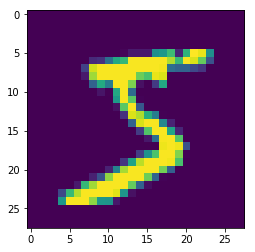

In [8]:
oneimg,label = train_data[0]
oneimg = oneimg.numpy().transpose(1,2,0) 
std = [0.5]
mean = [0.5]
oneimg = oneimg * std + mean
oneimg.resize(28,28)
plt.imshow(oneimg)
plt.show()

从三维生成一张黑白图片

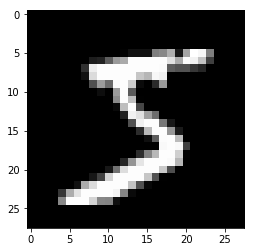

In [9]:
oneimg,label = train_data[0]
grid = utils.make_grid(oneimg)
grid = grid.numpy().transpose(1,2,0) 
std = [0.5]
mean = [0.5]
grid = grid * std + mean
plt.imshow(grid)
plt.show()

输出一个batch的图片和标签

tensor(4) tensor(7) tensor(6) tensor(6) tensor(1) tensor(2) tensor(1) tensor(3) 
tensor(2) tensor(9) tensor(6) tensor(2) tensor(5) tensor(0) tensor(7) tensor(1) 
tensor(6) tensor(2) tensor(2) tensor(3) tensor(7) tensor(2) tensor(2) tensor(3) 
tensor(4) tensor(6) tensor(3) tensor(3) tensor(8) tensor(3) tensor(6) tensor(6) 
tensor(7) tensor(4) tensor(3) tensor(0) tensor(2) tensor(1) tensor(2) tensor(0) 
tensor(3) tensor(9) tensor(2) tensor(2) tensor(4) tensor(5) tensor(7) tensor(0) 
tensor(5) tensor(0) tensor(5) tensor(8) tensor(3) tensor(9) tensor(8) tensor(2) 
tensor(7) tensor(5) tensor(8) tensor(2) tensor(6) tensor(8) tensor(9) tensor(1) 


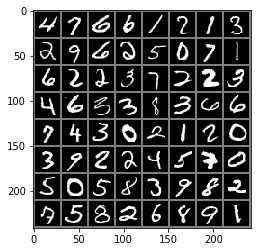

In [10]:
images, lables = next(iter(train_loader))
img = utils.make_grid(images)
# transpose 转置函数(x=0,y=1,z=2),新的x是原来的y轴大小，新的y是原来的z轴大小，新的z是原来的x大小
#相当于把x=1这个一道最后面去。
img = img.numpy().transpose(1,2,0) 
std = [0.5]
mean = [0.5]
img = img * std + mean
for i in range(64):
    print(lables[i], end=" ")
    i += 1
    if i%8 is 0:
        print(end='\n')
plt.imshow(img)
plt.show()

# **Step2.网络配置**
网络结构是两个卷积层，3个全连接层。

Conv2d参数
- in_channels(int) – 输入信号的通道数目
- out_channels(int) – 卷积产生的通道数目
- kerner_size(int or tuple) - 卷积核的尺寸
- stride(int or tuple, optional) - 卷积步长
- padding(int or tuple, optional) - 输入的每一条边补充0的层数

1.定义一个CNN网络

In [11]:
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
        self.fc1 = nn.Linear(64*7*7,1024)#两个池化，所以是7*7而不是14*14
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,10)
#         self.dp = nn.Dropout(p=0.5)
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
             
        x = x.view(-1, 64 * 7* 7)#将数据平整为一维的 
        x = F.relu(self.fc1(x))
#         x = self.fc3(x)
#         self.dp(x)
        x = F.relu(self.fc2(x))   
        x = self.fc3(x)  
#         x = F.log_softmax(x,dim=1) NLLLoss()才需要，交叉熵不需要
        return x
        
net = CNN()        

2.定义损失函数和优化函数

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#也可以选择Adam优化方法
# optimizer = torch.optim.Adam(net.parameters(),lr=1e-2)   

# **Step3.模型训练**

In [13]:
train_accs = []
train_loss = []
test_accs = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
for epoch in range(3):
    running_loss = 0.0
    for i,data in enumerate(train_loader,0):#0是下标起始位置默认为0
        # data 的格式[[inputs, labels]]       
#         inputs,labels = data
        inputs,labels = data[0].to(device), data[1].to(device)
        #初始为0，清除上个batch的梯度信息
        optimizer.zero_grad()         
        
        #前向+后向+优化     
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        # loss 的输出，每个一百个batch输出，平均的loss
        running_loss += loss.item()
        if i%100 == 99:
            print('[%d,%5d] loss :%.3f' %
                 (epoch+1,i+1,running_loss/100))
            running_loss = 0.0
        train_loss.append(loss.item())
        
        # 训练曲线的绘制 一个batch中的准确率
        correct = 0
        total = 0
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)# labels 的长度
        correct = (predicted == labels).sum().item() # 预测正确的数目
        train_accs.append(100*correct/total)
        
print('Finished Training')            

[1,  100] loss :2.292
[1,  200] loss :2.261
[1,  300] loss :2.195
[1,  400] loss :1.984
[1,  500] loss :1.337
[1,  600] loss :0.765
[1,  700] loss :0.520
[1,  800] loss :0.427
[1,  900] loss :0.385
[2,  100] loss :0.339
[2,  200] loss :0.301
[2,  300] loss :0.290
[2,  400] loss :0.260
[2,  500] loss :0.250
[2,  600] loss :0.245
[2,  700] loss :0.226
[2,  800] loss :0.218
[2,  900] loss :0.206
[3,  100] loss :0.183
[3,  200] loss :0.176
[3,  300] loss :0.174
[3,  400] loss :0.156
[3,  500] loss :0.160
[3,  600] loss :0.147
[3,  700] loss :0.146
[3,  800] loss :0.130
[3,  900] loss :0.115
Finished Training


模型的保存

In [15]:
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

# **Step4.模型评估**

画图

In [16]:
def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("acc(\%)", fontsize=20)
    plt.plot(iters, costs,color='red',label=label_cost) 
    plt.plot(iters, accs,color='green',label=lable_acc) 
    plt.legend()
    plt.grid()
    plt.show()

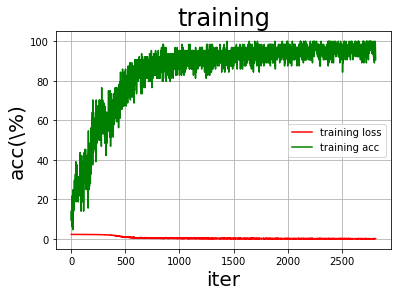

In [17]:
train_iters = range(len(train_accs))
draw_train_process('training',train_iters,train_loss,train_accs,'training loss','training acc')

检验一个batch的分类情况

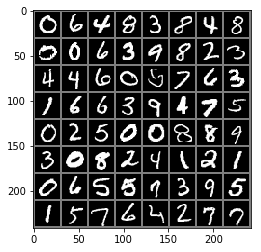

GroundTruth:  0 6 4 8 3 8 4 8 0 0 6 3 9 8 2 3 4 4 6 0 5 7 6 3 1 6 6 3 9 4 7 5 0 2 5 0 0 8 8 9 3 0 8 2 4 1 2 1 0 6 5 5 7 3 9 5 1 5 7 6 4 2 7 7


In [18]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
test_img = utils.make_grid(images)
test_img = test_img.numpy().transpose(1,2,0)
std = [0.5,0.5,0.5]
mean =  [0.5,0.5,0.5]
test_img = test_img*std+0.5
plt.imshow(test_img)
plt.show()
print('GroundTruth: ', ' '.join('%d' % labels[j] for j in range(64)))

In [21]:
test_net = CNN()
test_net.load_state_dict(torch.load(PATH))
test_out = test_net(images)

输出的是每一类的对应概率，所以需要选择max来确定最终输出的类别
dim=1 表示选择行的最大索引

In [23]:
_, predicted = torch.max(test_out, dim=1)

print('Predicted: ', ' '.join('%d' % predicted[j]
                              for j in range(64)))

Predicted:  0 6 4 8 3 8 4 8 0 0 6 3 9 8 2 3 4 4 6 0 6 7 6 3 1 6 6 3 9 6 7 5 0 2 5 0 0 2 8 9 3 0 8 2 4 1 2 1 0 6 5 5 9 3 9 5 1 5 7 6 4 2 7 7


测试集上面整体的准确率

In [24]:
correct = 0
total = 0
with torch.no_grad():# 进行评测的时候网络不更新梯度
    for data in test_loader:
        images, labels = data
        outputs = test_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)# labels 的长度
        correct += (predicted == labels).sum().item() # 预测正确的数目

print('Accuracy of the network on the  test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the  test images: 96 %


10个类别的准确率

In [25]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = test_net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)
#         print(predicted == labels)
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %d : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))

Accuracy of 0 : 99 %
Accuracy of 1 : 98 %
Accuracy of 2 : 96 %
Accuracy of 3 : 91 %
Accuracy of 4 : 97 %
Accuracy of 5 : 95 %
Accuracy of 6 : 96 %
Accuracy of 7 : 93 %
Accuracy of 8 : 94 %
Accuracy of 9 : 92 %


# 参考

https://aistudio.baidu.com/aistudio/projectdetail/307141

https://blog.csdn.net/weixin_45885232/article/details/103950992

https://zhuanlan.zhihu.com/p/30249139

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py